In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keybert
!pip install seaborn
!pip install konlpy

In [3]:
# 단어 빈도 및 워드 클라우드 한글 인식하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
## 런타임 다시시작.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,260 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123621 files and dire

## 라이브러리 임포트

In [3]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 데이터 전처리
import re

# keybert
from keybert import KeyBERT
from transformers import BertModel, BertTokenizer

# 형태소 분석
from konlpy.tag import Okt

# 네트워크 분석
import networkx as nx

# DTM 만들기
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# 데이터 가져오기

In [4]:
# 번역하고 싶은 문서
# 예산 축제 : 영상 수 = 144 ; 댓글 수 = 9384
# 대구 축제 : 영상 수 = 106 ; 댓글 수 = 1176
y_festival = pd.read_csv('/content/drive/MyDrive/big_contest/crawling_data/예산 맥주 페스티벌_youtube_comments_with_attributes.csv')
d_festival = pd.read_csv('/content/drive/MyDrive/big_contest/crawling_data/대구 치맥 페스티벌_youtube_comments_with_attributes.csv')
y_market = pd.read_csv('/content/drive/MyDrive/big_contest/crawling_data/예산 시장_youtube_comments_with_attributes.csv')
d_market = pd.read_csv('/content/drive/MyDrive/big_contest/crawling_data/서문시장_youtube_comments_with_attributes.csv')

In [5]:
# KeyBert 추출 csv Read
# joined: youtube
# joined_blog: blog
strings_Yjoined = pd.read_csv('/content/drive/MyDrive/big_contest/crawling_data/keybert_list/strings_Yjoined.csv')
strings_Yjoined_blog = pd.read_csv('/content/drive/MyDrive/big_contest/crawling_data/keybert_list/strings_Yjoined_blog.csv')
strings_Djoined = pd.read_csv('/content/drive/MyDrive/big_contest/crawling_data/keybert_list/strings_Djoined.csv')
strings_Djoined_blog = pd.read_csv('/content/drive/MyDrive/big_contest/crawling_data/keybert_list/strings_Djoined_blog.csv')

In [6]:
# 리스트 변환
strings_Yjoined = strings_Yjoined.iloc[:, 0].tolist()
strings_Yjoined_blog = strings_Yjoined_blog.iloc[:, 0].tolist()
strings_Djoined = strings_Djoined.iloc[:, 0].tolist()
strings_Djoined_blog = strings_Djoined_blog.iloc[:, 0].tolist()

In [7]:
# 결측값 제거
strings_Yjoined = [s for s in strings_Yjoined if pd.notna(s)]
strings_Yjoined_blog = [s for s in strings_Yjoined_blog if pd.notna(s)]
strings_Djoined = [s for s in strings_Djoined if pd.notna(s)]
strings_Djoined_blog = [s for s in strings_Djoined_blog if pd.notna(s)]

## 데이터 전처리

In [ ]:
combined_Ydata = pd.concat([y_market, y_festival], axis=0, ignore_index=True)
combined_Ddata = pd.concat([d_market, d_festival], axis=0, ignore_index=True)

In [8]:
# kobert를 임베딩 모델로 사용
model = BertModel.from_pretrained('monologg/kobert')
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
kw_model = KeyBERT(model=model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
keywords_list = []

for i in combined_Ydata['comment']:
    keywords = kw_model.extract_keywords(i, keyphrase_ngram_range=(1, 1), use_mmr=True, diversity=0.5)
    keywords_list.append(keywords)

# 수치만 제외하고 단어만 추출해서 리스트 안에 묶기
strings_Yjoined = [' '.join([word for word, _ in sublist]) for sublist in keywords_list]

# 결과 출력
strings_Yjoined

['예산 텃새가 웃기는 심하고 동네예요',
 '자본주의 사회주의 시장경제 국가도 대한민국이',
 '장사하는사람들이백대표가다해놓어니뒤통수치네백대표님 저런사람들도와주지마새요',
 '백씨너무싫다',
 '예산오지마라 진짜예산에서 꼴보기싫으니카 정도껏 백종원',
 '심해요 흉성은',
 '좋아져는데 왜그려지 건물주가 깨끗하고 예산',
 '익사해라 안고 점포',
 '시장사람들 예산시는 시장 버리고 아무도',
 '건강도 챙기세요 응원합니다',
 '갑질도 천벌 생계를 일해서 상인들이',
 '멍청하면 족발까지하셨기에 그기회를 울엄마가 포장마차',
 '건물 건물주들 이기적이고 세입자 필요가없어',
 '충청도는 충청도인가요 그래유 예산이',
 '손님이 안가야겠네요',
 '잘안믿는데 백종원씨는 믿습니다 저는 사람을',
 '지랄들 안되도 떨긴하지 싶으면 지랄들을',
 '건강하세요 힘내세요 응원합니다 입니다 존경합니다',
 '사람들안가게하자 건물주가 오픈해서 간단하게 퇴거',
 '씨발 너무하네 생각해야지 없던시절을 해도',
 '자본주의 일상이여',
 '무서버여 촌사람들이 비어서 했어요 건물',
 '붓기네요 소리안이지만 손을 길어 항아리',
 '그걸왜하는지모르는건물주들 그냥예산가지맙시다',
 '맛없는떡도 욕심나니 발라놓으니',
 '건물주들 양심없는',
 '몰랐어 장사꾼이',
 '놈이잖아 요리하던 예의도 갑질하는 백종원이',
 '건물주들이 돈벌겠다는 백종원이 가게세 다해놓으니',
 '장사하는데 표시해서 뺏어서 가지말기',
 '십년이면 계약기간 놓으면주인들이 하려고도로다 뺏음',
 '건강필승 백종원대표님 쉬어가면서 시장에 해외',
 '화이팅하세요 많아요 백종원님 감사할줄 사람들이',
 '40분 국수 한그릇을 기다렸어요 3국축제하는데',
 '대단하다 그저그런 방송의 음식 위력이',
 '건물주들 이기심만 식당가는 이태원 홍대',
 '건물주들 응원 하세요 경제를 항상',
 '하지마시요 진짜 그런짓 건물주들',
 '건물주의퇴거통보 속이보이네 끝났네 아산시장',
 '마음이큰사람 그래서복이만은사람',


In [ ]:
# 키워드 추출 데이터 csv 저장
import csv

# 리스트를 CSV 파일로 저장
with open('/content/strings_Yjoined.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    for item in strings_Yjoined:
        writer.writerow([item])  # 각 리스트 요소를 한 행에 저장

In [ ]:
keywords_list = []

for i in combined_Ddata['comment']:
    keywords = kw_model.extract_keywords(i, keyphrase_ngram_range=(1, 1), use_mmr=True, diversity=0.5)
    keywords_list.append(keywords)

# 수치만 제외하고 단어만 추출해서 리스트 안에 묶기
strings_Djoined = [' '.join([word for word, _ in sublist]) for sublist in keywords_list]


# 결과 출력
strings_Djoined

['일본에 팔고 나라를 놈들 단어만',
 '이집25년전에 저는 국수삶고 오후새참 골목에서',
 '서문시장에서 서문시장가면 집에 맛있다 제일',
 '서문시장은 매국노 국힘놈들만 처먹어라 텃밭',
 '감사합니다 공유해 궁금합니다 어느 수고하세요',
 '드러워',
 '빠진애들 득본다더라 휼뎜에 환장하고 엠쥐들',
 '그닥 위생은',
 '튀게 pd님요 자꾸 요리하시는데 사장님',
 '상호가무었인가요',
 '서문시장위치가어딘지알고싶내요',
 '짐승과 없다고 동족들아 사람을 선거',
 '오홍 혼나용',
 '대구 서문시장역',
 '지금도하나요',
 'shundan raman yeb bo ko',
 'beautiful',
 '먹으면 맛있게 먹음 질질싼다 항상',
 '마싯어보임 진짜 포동포동',
 '대박',
 '생크림이랑먹으면 맛있어요',
 'ㅠㅠ 진짜 맛있겠다',
 'попробовааааааать хочу как это',
 '커피랑 맛있음 같이먹으면 몇번 폭신폭신',
 '있었는데 사람들의 방송사올때 어느날 식용유',
 '안되고 자를수 정확히 달인이면 있지',
 '눈물 나게 입에서 못하긋나 확실히',
 '자를때 자를 대버리넹 갖다',
 '',
 '사장님의 크기의 모두한테 오래 물론',
 '',
 '맛있어 멸종 집근처에도 p6g8y 누구',
 'ㅈ같이못하네 아재요 ㅋㅋ 뭐라노',
 '지랄',
 '적게주고 많이주면 안되죠 누군',
 '안되니 무식한건 죄야 대면',
 '아니고 저자로 연필끄적이는것도 대괄없냐',
 '칼은 되고 자는 안됨',
 'cake food sponge angel looks',
 '카스테라',
 'mother grand',
 '맛집 서문시장 큰장로26길 얼큰이손수제비 고추가',
 'ㅠㅠ전 칼제비 최고에요 층에 청양고추',
 'ㅎㅎㅎㅎㅎㅎ 포장되는지 궁금해요',
 '땡겨요 드세요 병원에 ㅠㅠ 수제비로',
 '잘하고요 3종 영상시청 비타민 많아',
 '밑에 가면 저렇다',
 '별로던데',
 '경남분이신가 부산이나 말투가',
 '묵으러가셈 한번쯤 존맛임 요기',


In [ ]:
# 키워드 추출 데이터 csv 저장
import csv

# 리스트를 CSV 파일로 저장
with open('/content/strings_Djoined.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    for item in strings_Djoined:
        writer.writerow([item])  # 각 리스트 요소를 한 행에 저장

In [9]:
# 명사, 형용사, 수사, 해시태그, etc 등 분리함수 만들기
def okt_token(text):
  okt = Okt()
  words_list = []
  stop_words = ['하다', '있다', '되어다']
  morp = okt.pos(text, stem = True)

  for word, tag in morp:
    if (tag =='Noun' or tag =='Number' or tag == 'Adjective' or tag == 'Hashtag') and (len(word) > 1) and (word not in stop_words):
        words_list.append(word)

  return words_list

# 예산시장, 예산 맥주 페스티벌 분석 (Youtube)

## DTM 만들기

In [10]:
Ycv_youtube = CountVectorizer(ngram_range = (1, 1),
                     tokenizer = okt_token)

In [11]:
Ydtm_counts_youtube = Ycv_youtube.fit_transform(strings_Yjoined)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# 데이터 확인
Ydtm_df_youtube = pd.DataFrame(Ydtm_counts_youtube.todense().tolist(),
                     columns = Ycv_youtube.get_feature_names_out())
Ydtm_df_youtube

,00,000,000001,0000원,000원,007,00시,01,019,0191,...,희한하다,희힇,흰색,히키코모리,힐링,힘겹다,힘드다,힘드럿음,힘들다,힘차다
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31318,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Term to Term Matrix

In [13]:
Yttm_counts_youtube = (Ydtm_counts_youtube.T * Ydtm_counts_youtube)
# 본인에 해당하는 대각행렬 = 0
Yttm_counts_youtube.setdiag(0)

In [14]:
# term-to-term matrix
Yttm_df_youtube = pd.DataFrame(Yttm_counts_youtube.todense().tolist(),
                      columns = Ycv_youtube.get_feature_names_out(),
                      index = Ycv_youtube.get_feature_names_out())

In [15]:
Yttm_df_youtube

,00,000,000001,0000원,000원,007,00시,01,019,0191,...,희한하다,희힇,흰색,히키코모리,힐링,힘겹다,힘드다,힘드럿음,힘들다,힘차다
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000원,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000원,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
힘겹다,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힘드다,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힘드럿음,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힘들다,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


## Centrality 계산

In [16]:
# 인접행렬 가져오기
YG_youtube = nx.from_pandas_adjacency(Yttm_df_youtube)

In [17]:
# Degree of centrality
Ydc_youtube = nx.degree_centrality(YG_youtube)
Ydc_df_youtube = sorted(Ydc_youtube.items(), key = lambda x: x[1], reverse = True)
Ydc_df_youtube = pd.DataFrame(list(Ydc_df_youtube)[:100],
                     columns = ['word', 'dc'])
Ydc_df_youtube

,word,dc
0,예산,0.174560
1,백종원,0.147136
2,없다,0.131868
3,축제,0.129631
4,아니다,0.123213
...,...,...
95,역시,0.021978
96,업자,0.021589
97,자본주의,0.021297
98,바가지,0.021200


In [18]:
# closeness of centrality
Ycc_youtube = nx.closeness_centrality(YG_youtube)
Ycc_df_youtube = sorted(Ycc_youtube.items(), key = lambda x : x[1], reverse = True)
Ycc_df_youtube = pd.DataFrame(list(Ycc_df_youtube)[:100],
                     columns = ['word', 'cc'])
Ycc_df_youtube

,word,cc
0,예산,0.514437
1,백종원,0.503649
2,없다,0.497048
3,사람,0.495554
4,축제,0.495246
...,...,...
95,재밌다,0.429642
96,모두,0.429622
97,힘들다,0.429487
98,정부,0.429160


In [ ]:
Ycc_df_youtube[:50]

,word,cc
0,예산,0.514437
1,백종원,0.503649
2,없다,0.497048
3,사람,0.495554
4,축제,0.495246
5,아니다,0.494938
6,좋다,0.494682
7,시장,0.491679
8,대표,0.488114
9,같다,0.481015


In [19]:
# betweenness of centrality
Ybc_youtube = nx.betweenness_centrality(YG_youtube)
Ybc_df_youtube = sorted(Ybc_youtube.items(), key = lambda x : x[1], reverse = True)
Ybc_df_youtube = pd.DataFrame(list(Ybc_df_youtube)[:100],
                     columns = ['word', 'dc'])
Ybc_df_youtube

,word,dc
0,예산,0.079455
1,백종원,0.067905
2,없다,0.050373
3,아니다,0.050329
4,사람,0.046730
...,...,...
95,방송,0.002988
96,욕심,0.002949
97,코리아,0.002929
98,우리나라,0.002895


In [20]:
# centrality 종합표 만들기
Ytemp_youtube = pd.merge(Ydc_df_youtube, Ycc_df_youtube, how = 'outer', on = 'word')
Ycentrality_df_youtube = pd.merge(Ytemp_youtube, Ybc_df_youtube, how = 'outer', on = 'word')
Ycentrality_df_youtube

,word,dc_x,cc,dc_y
0,10,NaN,NaN,0.002874
1,가게,0.040455,0.446063,0.006999
2,가격,0.066323,0.466392,0.014660
3,감사,0.023923,NaN,0.003158
4,강아지,0.040747,0.445294,0.008178
...,...,...,...,...
110,한번,0.022173,0.433756,0.004196
111,항상,0.033356,0.447546,0.005716
112,행복하다,0.044929,0.454289,0.010444
113,행사,0.022853,NaN,NaN


## network graph

In [21]:
YG = nx.from_pandas_adjacency(Yttm_df_youtube)

In [22]:
print(YG_youtube.number_of_nodes())
print(YG_youtube.number_of_edges())

10284
92929


In [23]:
# 필요없는 것들을 쪼개서 없애주자.
# - 연결 강도가 강한 것들만 뽑기
# - 연결 수준이 일정 수준 있는 것만 택하기

# edge 숫자 조정
edge_weight = 20
YG_edge_youtube = nx.Graph()

YG_edge_youtube.add_nodes_from(YG_youtube.nodes(data = True))
Yedges_youtube = filter(lambda e : True if e[2]['weight'] >= edge_weight else False, YG_youtube.edges(data = True))
YG_edge_youtube.add_edges_from(Yedges_youtube)

# 필요없는 노드들 제거
for n in YG_youtube.nodes():
  if len(list(nx.all_neighbors(YG_edge_youtube, n))) == 0:
    YG_edge_youtube.remove_node(n)

In [24]:
print(YG_edge_youtube.number_of_nodes())
print(YG_edge_youtube.number_of_edges())

186
422


In [64]:
# networkx to Gephi
nx.write_gexf(YG, "/content/drive/MyDrive/big_contest/network_YG_youtube.gexf")
nx.write_gexf(YG_edge_youtube, "/content/drive/MyDrive/big_contest/network_YG_edge_youtube.gexf")

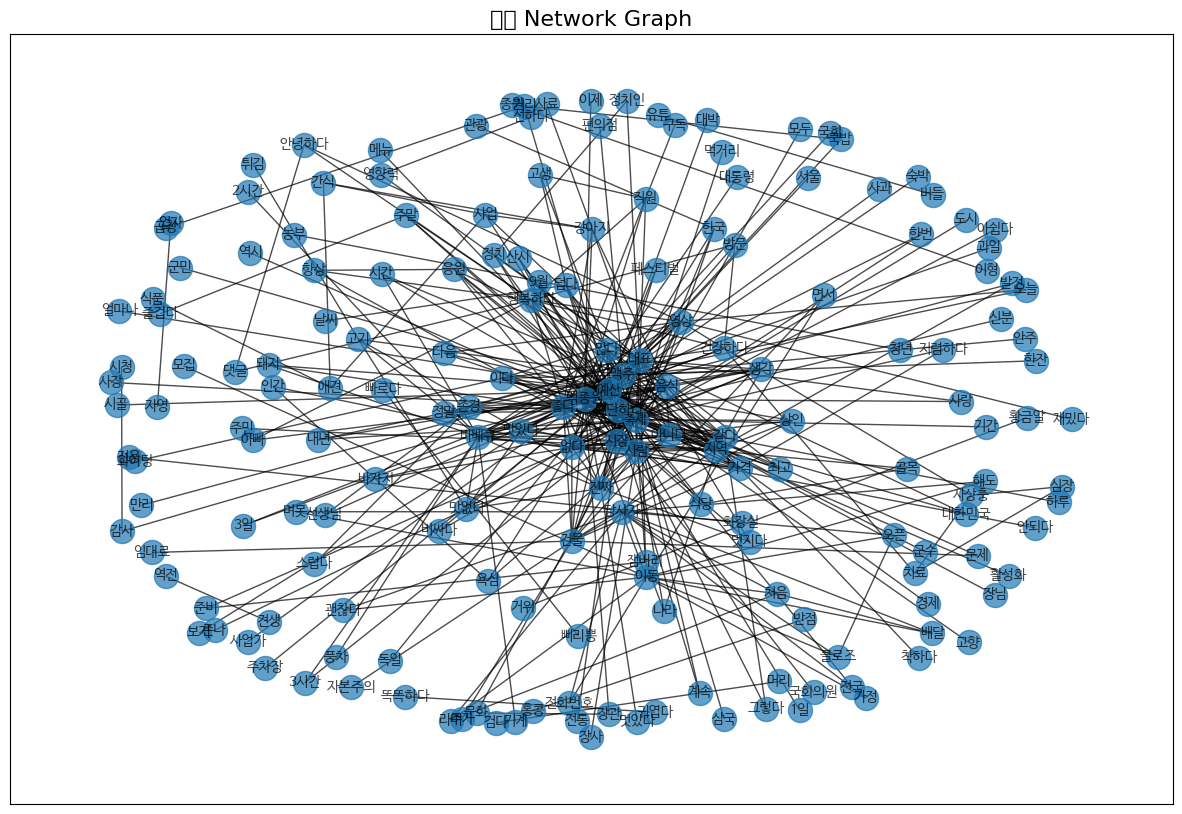

In [ ]:
plt.figure(figsize = (15, 10))
plt.title('예산 Network Graph', fontsize = 16)

# 그래프 그리기
Ypos_youtube = nx.spring_layout(YG_edge_youtube, k=2.0)  # k 값을 조정하여 노드 간 거리 증가


nx.draw_networkx(YG_edge_youtube,
                 pos=Ypos,
                 font_family='NanumBarunGothic',
                 font_color='black',
                 with_labels=True,
                 font_size=10,
                 cmap=plt.cm.Blues,
                 alpha=0.7)

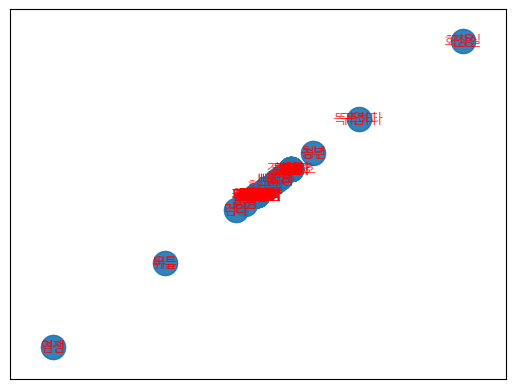

In [ ]:
Ypos_youtube = nx.spectral_layout(YG_edge_youtube, scale=15.0)
nx.draw_networkx(YG_edge_youtube,
                 pos=Ypos,
                 font_family='NanumBarunGothic',
                 font_color='red',
                 with_labels=True,
                 font_size=10,
                 cmap=plt.cm.Blues,
                 alpha=0.7)

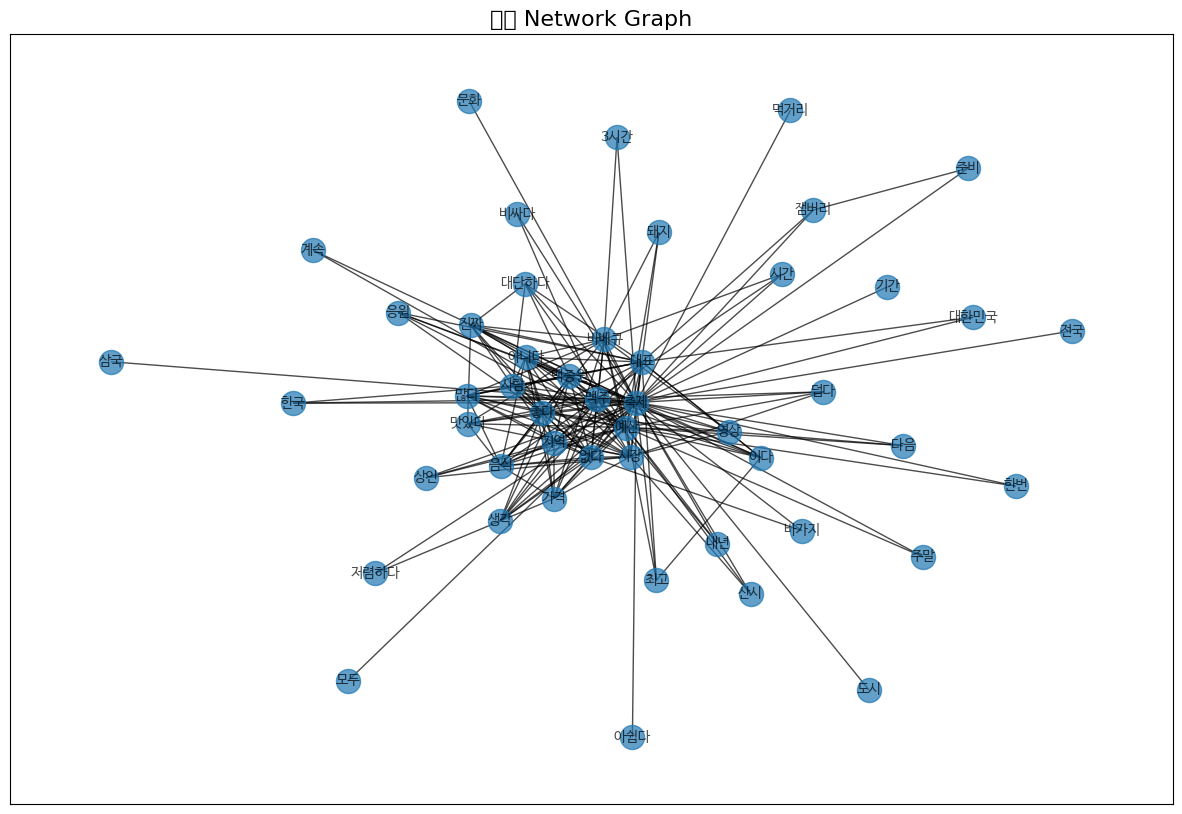

In [ ]:
# ego network: 특정 단어가 연결된 것을 봄.
# YG_youtube로 할건지, YG_edge_youtube로 할건지 결정
# YG는 전부, YG는 엣지 가중치 위주
YG_ego_youtube = nx.ego_graph(YG_edge_youtube, '축제')
plt.figure(figsize = (15, 10))
plt.title('예산 Network Graph', fontsize = 16)

# 그래프 그리기
Ypos = nx.spring_layout(YG_ego, k=2.0)  # k 값을 조정하여 노드 간 거리 증가


nx.draw_networkx(YG_ego_youtube,
                 pos=Ypos,
                 font_family='NanumBarunGothic',
                 font_color='black',
                 with_labels=True,
                 font_size=10,
                 cmap=plt.cm.Blues,
                 alpha=0.7)

# 서문시장, 대구 치맥 페스티벌 분석 (Youtube)

### DTM 만들기

In [27]:
Dcv_youtube = CountVectorizer(ngram_range = (1, 1),
                     tokenizer = okt_token)

In [28]:
Ddtm_counts_youtube = Dcv_youtube.fit_transform(strings_Djoined)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:
# 데이터 확인
Ddtm_df_youtube = pd.DataFrame(Ddtm_counts_youtube.todense().tolist(),
                     columns = Dcv_youtube.get_feature_names_out())
Ddtm_df_youtube

,00,000,000원,01,012,02,04,07,0825,10,...,흥해,희노애락,희다,희뜩하,희망,히든싱어,힐링,힘드다,힘들다,힙합
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4084,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Term to Term Matrix

In [30]:
Dttm_counts_youtube = (Ddtm_counts_youtube.T * Ddtm_counts_youtube)
# 본인에 해당하는 대각행렬 = 0
Dttm_counts_youtube.setdiag(0)

In [31]:
Dttm_df_youtube = pd.DataFrame(Dttm_counts_youtube.todense().tolist(),
                      columns = Dcv_youtube.get_feature_names_out(),
                      index = Dcv_youtube.get_feature_names_out())

In [32]:
Dttm_df_youtube

,00,000,000원,01,012,02,04,07,0825,10,...,흥해,희노애락,희다,희뜩하,희망,히든싱어,힐링,힘드다,힘들다,힙합
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000원,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히든싱어,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힐링,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힘드다,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힘들다,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Centrality 계산

In [33]:
# 인접행렬 가져오기
DG_youtube = nx.from_pandas_adjacency(Dttm_df_youtube)

In [34]:
# Degree of centrality
Ddc_youtube = nx.degree_centrality(DG_youtube)
Ddc_df_youtube = sorted(Ddc_youtube.items(), key = lambda x: x[1], reverse = True)
Ddc_df_youtube = pd.DataFrame(list(Ddc_df_youtube)[:100],
                     columns = ['word', 'dc'])

In [35]:
Ddc_df_youtube

,word,dc
0,플라스틱,0.119816
1,좋다,0.091353
2,서문시장,0.084847
3,맛있다,0.079425
4,없다,0.077799
...,...,...
95,에디,0.018433
96,연락,0.018433
97,외보,0.018433
98,을릉,0.018433


In [36]:
# closeness of centrality
Dcc_youtube = nx.closeness_centrality(DG_youtube)
Dcc_df_youtube = sorted(Dcc_youtube.items(), key = lambda x : x[1], reverse = True)
Dcc_df_youtube = pd.DataFrame(list(Dcc_df_youtube)[:100],
                     columns = ['word', 'cc'])
Dcc_df_youtube

,word,cc
0,좋다,0.438780
1,플라스틱,0.435978
2,없다,0.433213
3,맛있다,0.433154
4,아니다,0.423719
...,...,...
95,홍보,0.351052
96,엄마,0.351014
97,서울,0.350899
98,발암,0.350861


In [37]:
# betweenness of centrality
Dbc_youtube = nx.betweenness_centrality(DG_youtube)
Dbc_df_youtube = sorted(Dbc_youtube.items(), key = lambda x : x[1], reverse = True)
Dbc_df_youtube = pd.DataFrame(list(Dbc_df_youtube)[:100],
                     columns = ['word', 'dc'])
Dbc_df_youtube

,word,dc
0,플라스틱,0.107095
1,좋다,0.071059
2,서문시장,0.070323
3,없다,0.067589
4,맛있다,0.064915
...,...,...
95,내년,0.003629
96,동네,0.003615
97,혼자,0.003594
98,이준석,0.003557


In [39]:
# centrality 종합표 만들기
Dtemp_youtube = pd.merge(Ddc_df_youtube, Dcc_df_youtube, how = 'outer', on = 'word')
Dcentrality_df_youtube = pd.merge(Dtemp_youtube, Dbc_df_youtube, how = 'outer', on = 'word')
Dcentrality_df_youtube

,word,dc_x,cc,dc_y
0,20,NaN,NaN,0.005294
1,가게,0.034156,0.376016,0.007936
2,가격,NaN,0.358063,0.007263
3,가면,NaN,0.378365,0.007117
4,가요,NaN,0.361043,0.004190
...,...,...,...,...
163,호르몬,NaN,0.359184,NaN
164,혼자,NaN,NaN,0.003594
165,홍보,NaN,0.351052,NaN
166,화이팅,NaN,0.358823,0.007443


### network graph

In [ ]:
DG_youtube = nx.from_pandas_adjacency(Dttm_df_youtube)

In [ ]:
print(DG_youtube.number_of_nodes())
print(DG_youtube.number_of_edges())

3690
18794


In [65]:
# 필요없는 것들을 쪼개서 없애주자.
# - 연결 강도가 강한 것들만 뽑기
# - 연결 수준이 일정 수준 있는 것만 택하기

# edge 숫자 조정
edge_weight = 10
DG_edge_youtube = nx.Graph()

DG_edge_youtube.add_nodes_from(DG_youtube.nodes(data = True))
Dedges_youtube = filter(lambda e : True if e[2]['weight'] >= edge_weight else False, DG_youtube.edges(data = True))
DG_edge_youtube.add_edges_from(Dedges_youtube)

# 필요없는 노드들 제거
for n in DG_youtube.nodes():
  if len(list(nx.all_neighbors(DG_edge_youtube, n))) == 0:
    DG_edge_youtube.remove_node(n)

In [66]:
print(DG_edge_youtube.number_of_nodes())
print(DG_edge_youtube.number_of_edges())

66
143


In [67]:
# networkx to Gephi
nx.write_gexf(DG_youtube, "/content/drive/MyDrive/big_contest/network_DG_youtube.gexf")
nx.write_gexf(DG_edge_youtube, "/content/drive/MyDrive/big_contest/network_DG_edge_youtube.gexf")

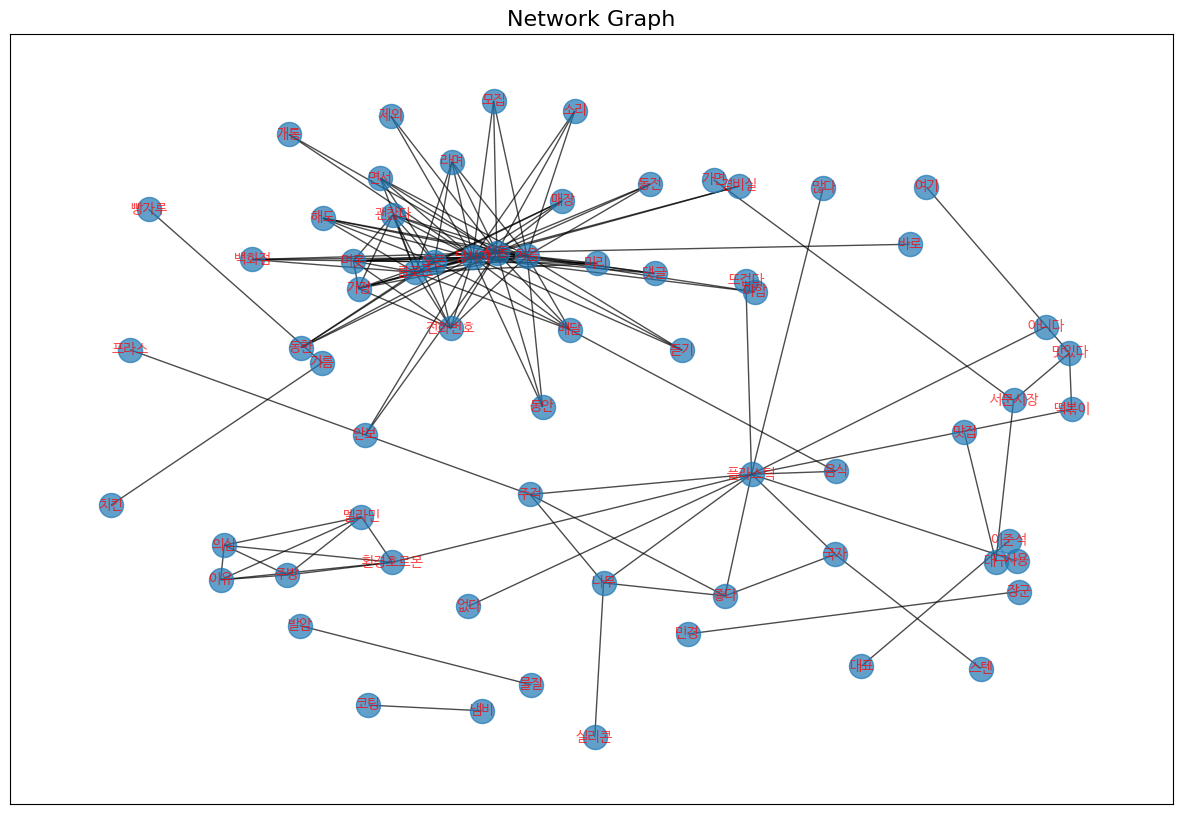

In [ ]:
plt.figure(figsize = (15, 10))
plt.title('Network Graph', fontsize = 16)

# 그래프 그리기
pos = nx.spring_layout(DG_edge_youtube, k=1.5)  # k 값을 조정하여 노드 간 거리 증가


nx.draw_networkx(DG_edge_youtube,
                 pos=pos,
                 font_family='NanumBarunGothic',
                 font_color='red',
                 with_labels=True,
                 font_size=10,
                 cmap=plt.cm.Blues,
                 alpha=0.7)

# 예산시장, 예산 맥주 페스티벌 분석 (Blog)

## DTM 만들기

In [41]:
# 예산시장
Ycv_blog = CountVectorizer(ngram_range = (1, 1),
                     tokenizer = okt_token)

In [42]:
Ydtm_counts_blog = Ycv_blog.fit_transform(strings_Yjoined_blog)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [43]:
# 데이터 확인
Ydtm_df_blog = pd.DataFrame(Ydtm_counts_blog.todense().tolist(),
                     columns = Ycv_blog.get_feature_names_out())
Ydtm_df_blog

,00,0002439633,0007023860,000억,000원,0032,0067,007,01,010,...,휴무,휴업,휴일,흐규규귭,흐름,흡연,흡입,힐링,힘드다,힙합
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Term to Term Matrix

In [44]:
Yttm_counts_blog = (Ydtm_counts_blog.T * Ydtm_counts_blog)
# 본인에 해당하는 대각행렬 = 0
Yttm_counts_blog.setdiag(0)

In [45]:
Yttm_df_blog = pd.DataFrame(Yttm_counts_blog.todense().tolist(),
                      columns = Ycv_blog.get_feature_names_out(),
                      index = Ycv_blog.get_feature_names_out())

In [46]:
Yttm_df_blog

,00,0002439633,0007023860,000억,000원,0032,0067,007,01,010,...,휴무,휴업,휴일,흐규규귭,흐름,흡연,흡입,힐링,힘드다,힙합
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0002439633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0007023860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000억,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000원,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
흡연,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
흡입,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힐링,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힘드다,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Centrality 계산

In [47]:
# 인접행렬 가져오기
YG_blog = nx.from_pandas_adjacency(Yttm_df_blog)

In [48]:
# Degree of centrality
Ydc_blog = nx.degree_centrality(YG_blog)
Ydc_df_blog = sorted(Ydc_blog.items(), key = lambda x: x[1], reverse = True)
Ydc_df_blog = pd.DataFrame(list(Ydc_df_blog)[:100],
                     columns = ['word', 'dc'])
Ydc_df_blog

,word,dc
0,예산,0.627816
1,시장,0.526934
2,2023,0.236043
3,맥주,0.226738
4,산시,0.219882
...,...,...
95,정보,0.023017
96,9시,0.022527
97,사진,0.022527
98,터미널,0.022527


In [49]:
# closeness of centrality
Ycc_blog = nx.closeness_centrality(YG_blog)
Ycc_df_blog = sorted(Ycc_blog.items(), key = lambda x : x[1], reverse = True)
Ycc_df_blog = pd.DataFrame(list(Ycc_df_blog)[:100],
                     columns = ['word', 'cc'])
Ycc_df_blog

,word,cc
0,예산,0.723711
1,시장,0.672895
2,2023,0.555813
3,산시,0.549769
4,맥주,0.549619
...,...,...
95,15분,0.465160
96,자마자,0.464946
97,3시,0.464839
98,2시,0.464732


In [50]:
# betweenness of centrality
Ybc_blog = nx.betweenness_centrality(YG_blog)
Ybc_df_blog = sorted(Ybc_blog.items(), key = lambda x : x[1], reverse = True)
Ybc_df_blog = pd.DataFrame(list(Ybc_df_blog)[:100],
                     columns = ['word', 'dc'])
Ybc_df_blog

,word,dc
0,예산,0.348686
1,시장,0.208498
2,산시,0.072205
3,2023,0.059416
4,맥주,0.041259
...,...,...
95,우수,0.001723
96,음식,0.001704
97,투어,0.001657
98,사진,0.001638


In [51]:
# centrality 종합표 만들기
Ytemp_blog = pd.merge(Ydc_df_blog, Ycc_df_blog, how = 'outer', on = 'word')
Ycentrality_df_blog = pd.merge(Ytemp_blog, Ybc_df_blog, how = 'outer', on = 'word')
Ycentrality_df_blog

,word,dc_x,cc,dc_y
0,041,0.047992,0.483628,0.006174
1,0507,0.025955,NaN,NaN
2,100,NaN,NaN,0.001826
3,10시,0.024976,0.472662,NaN
4,11시,0.029383,0.474659,0.001633
...,...,...,...,...
136,한국,0.062684,0.491146,0.014413
137,할인,0.023506,NaN,0.004597
138,행사,NaN,0.470025,NaN
139,혁신,NaN,NaN,0.002849


## network graph

In [68]:
# 필요없는 것들을 쪼개서 없애주자.
# - 연결 강도가 강한 것들만 뽑기
# - 연결 수준이 일정 수준 있는 것만 택하기

# edge 숫자 조정
edge_weight = 10
YG_edge_blog = nx.Graph()

YG_edge_blog.add_nodes_from(YG_blog.nodes(data = True))
YG_edges_blog = filter(lambda e : True if e[2]['weight'] >= edge_weight else False, YG_blog.edges(data = True))
YG_edge_blog.add_edges_from(YG_edges_blog)

# 필요없는 노드들 제거
for n in YG_blog.nodes():
  if len(list(nx.all_neighbors(YG_edge_blog, n))) == 0:
    YG_edge_blog.remove_node(n)

In [69]:
print(YG_edge_blog.number_of_nodes())
print(YG_edge_blog.number_of_edges())

117
283


In [70]:
# networkx to Gephi
nx.write_gexf(YG_blog, "/content/drive/MyDrive/big_contest/network_YG_blog.gexf")
nx.write_gexf(YG_edge_blog, "/content/drive/MyDrive/big_contest/network_YG_edge_blog.gexf")

# 서문시장, 대구 치맥 페스티벌 분석 (Blog)

## DTM 만들기

In [53]:
Dcv_blog = CountVectorizer(ngram_range = (1, 1),
                     tokenizer = okt_token)

In [54]:
Ddtm_counts_blog = Dcv_blog.fit_transform(strings_Djoined_blog)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [55]:
# 데이터 확인
Ddtm_df_blog = pd.DataFrame(Ddtm_counts_blog.todense().tolist(),
                     columns = Dcv_blog.get_feature_names_out())
Ddtm_df_blog

,00,000,0000045821,000원,0064,010,022,0221,02시,03,...,휴대폰,휴무,휴식,흠뻑,희망,히히히,힐링,힐스,힘들다,힙합
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Term to Term Matrix

In [56]:
Dttm_counts_blog = (Ddtm_counts_blog.T * Ddtm_counts_blog)
# 본인에 해당하는 대각행렬 = 0
Dttm_counts_blog.setdiag(0)

In [57]:
Dttm_df_blog = pd.DataFrame(Dttm_counts_blog.todense().tolist(),
                      columns = Dcv_blog.get_feature_names_out(),
                      index = Dcv_blog.get_feature_names_out())

In [58]:
Dttm_df_blog

,00,000,0000045821,000원,0064,010,022,0221,02시,03,...,휴대폰,휴무,휴식,흠뻑,희망,히히히,힐링,힐스,힘들다,힙합
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000045821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000원,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
히히히,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힐링,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힐스,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
힘들다,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Centrality 계산

In [59]:
# 인접행렬 가져오기
DG_blog = nx.from_pandas_adjacency(Dttm_df_blog)

In [60]:
# Degree of centrality
Ddc_blog = nx.degree_centrality(DG_blog)
Ddc_df_blog = sorted(Ddc_blog.items(), key = lambda x: x[1], reverse = True)
Ddc_df_blog = pd.DataFrame(list(Ddc_df_blog)[:100],
                     columns = ['word', 'dc'])
Ddc_df_blog

,word,dc
0,2023,0.313228
1,50,0.219634
2,대구,0.208819
3,서문시장,0.173877
4,페스티벌,0.158902
...,...,...
95,8090,0.021215
96,경북,0.021215
97,대구광역시,0.021215
98,안전,0.021215


In [61]:
# closeness of centrality
Dcc_blog = nx.closeness_centrality(DG_blog)
Dcc_df_blog = sorted(Dcc_blog.items(), key = lambda x : x[1], reverse = True)
Dcc_df_blog = pd.DataFrame(list(Dcc_df_blog)[:100],
                     columns = ['word', 'cc'])
Dcc_df_blog

,word,cc
0,2023,0.576459
1,50,0.543207
2,대구,0.534938
3,서문시장,0.518559
4,페스티벌,0.514705
...,...,...
95,요금,0.432689
96,좋다,0.432609
97,야시장,0.431974
98,마켓,0.431895


In [72]:
# betweenness of centrality
Dbc_blog = nx.betweenness_centrality(DG_blog)
Dbc_df_blog = sorted(Dbc_blog.items(), key = lambda x : x[1], reverse = True)
Dbc_df_blog = pd.DataFrame(list(Dbc_df_blog)[:100],
                     columns = ['word', 'dc'])
Dbc_df_blog

,word,dc
0,2023,0.217410
1,50,0.127129
2,대구,0.088943
3,서문시장,0.077795
4,맛집,0.045170
...,...,...
95,닭발,0.003335
96,대회,0.003331
97,아프다,0.003289
98,평화시장,0.003223


In [73]:
# centrality 종합표 만들기
Dtemp_blog = pd.merge(Ddc_df_blog, Dcc_df_blog, how = 'outer', on = 'word')
Dcentrality_df_blog = pd.merge(Dtemp_blog, Dbc_df_blog, how = 'outer', on = 'word')
Dcentrality_df_blog

,word,dc_x,cc,dc_y
0,04,0.026206,0.438328,0.005875
1,0507,0.024958,0.442032,NaN
2,10,0.022879,0.438410,NaN
3,100,0.023710,NaN,0.003373
4,10분,0.026206,0.448772,0.005968
...,...,...,...,...
129,피자,NaN,NaN,0.004234
130,한국,0.078203,0.472269,0.022975
131,한복,NaN,NaN,0.003506
132,할인,0.050749,0.471229,0.012006


## network graph

In [76]:
# 필요없는 것들을 쪼개서 없애주자.
# - 연결 강도가 강한 것들만 뽑기
# - 연결 수준이 일정 수준 있는 것만 택하기

# 엣지 가중치 임계값 설정
edge_weight = 10
DG_edge_blog = nx.Graph()

# 노드를 추가하고 엣지를 가중치에 따라 필터링
DG_edge_blog.add_nodes_from(DG_blog.nodes(data=True))
DG_edges_blog = filter(lambda e: True if e[2]['weight'] >= edge_weight else False, DG_blog.edges(data=True))
DG_edge_blog.add_edges_from(DG_edges_blog)

# 이웃이 없는 노드를 안전하게 제거
for n in list(DG_blog.nodes()):  # list()를 사용하여 반복 중 그래프를 수정하지 않도록 처리
    if n in DG_edge_blog and len(list(nx.all_neighbors(DG_edge_blog, n))) == 0:
        DG_edge_blog.remove_node(n)

In [77]:
print(DG_edge_blog.number_of_nodes())
print(DG_edge_blog.number_of_edges())

68
139


In [78]:
# networkx to Gephi
nx.write_gexf(DG_blog, "/content/drive/MyDrive/big_contest/network_DG_blog.gexf")
nx.write_gexf(DG_edge_blog, "/content/drive/MyDrive/big_contest/network_DG_edge_blog.gexf")